In [1413]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)

In [1414]:
# This function will clean the text of email bodies by: 1. removing numbers, 
# 2. keeping only words longer than 4 letters. Ensuring each word is 
# part of the NLTK english language corpus led to exponential runtime.
def text_cleaner(string):
    split_words = re.findall("[^\d_\W]+", string)
    split_words = [word for word in split_words if len(word) > 4]
    # split_words = [word for word in split_words if word in words.words()]
    return " ".join(split_words)

# Returns 1 if the date inputted is during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
def in_school_year(date):
    month = int(re.findall(".+?(?=/)", date)[0])
    school_months = [1, 2, 3, 4, 9, 10, 11, 12]
    if month > 0 and month < 13:
        if month in school_months:
            return 1
        else:
            return 0
    else:
        return None
    
# Beautiful confusion matrix plotter from the Data 100 Berkeley textbook:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    
def preprocessor(table):
    #The inputted table must follow the following schema:
    # Basic pre-processing: 
    # 1. Select only relevant columns.
    table = table[["Date & Time Received", "From", "Subject", "Email Text", "Related"]].dropna().reset_index()
    # 2. Use regex to help extract the sender domain from the emails.
    table["From"] = table["From"].apply((lambda x: re.findall("(?<=@)[^.]+(?=\.)", x)[0].replace("-", " ")))
    # 3. Clean email subject and body text using function defined above. 
    table["Email Text"] = table["Email Text"].apply(text_cleaner)
    table["Subject"] = table["Subject"].apply(text_cleaner)

    # Let's do some feature engineering:
    # 1. Add a few feature that indicate 1 if the email was sent during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
    table["In School Year"] = table["Date & Time Received"].apply(in_school_year)
    # 2. Add a few feature that shows the length of the email, normalizing by the average length of a word in the email.
    table["Length"] = table["Email Text"].apply(lambda string: len(string))
    table["Length"] = StandardScaler().fit_transform(np.array(table["Length"]).reshape(-1, 1))
    # 3. Create vectorized representations of whether email is from a specific top sender.
    sv = CountVectorizer(lowercase=True, ngram_range = (1,2))
    sender_counts = sv.fit_transform(table['From'])
    sender_vectors = pd.DataFrame(sender_counts.todense(), columns=["Sender: " + i for i in sv.get_feature_names()])
    # Rename the final column
    table = table[["From", "Subject", "Email Text", "In School Year", "Length", "Related"]].rename(columns={"Related": "Internship-Related"})
    table = pd.concat([table, sender_vectors], axis=1)
    
    return table

def get_top_senders(table, count):
    return table["From"].value_counts().to_frame().head(count).rename(columns={"From": "Counts"})

def cv_and_tfidf_vectorize(table):
    # Use CountVectorizer to create a matrix representation of the words used across all emails:
    cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
    cv_word_counts = cv.fit_transform(table['Email Text'])

    # Vectorized dictionary representation of each email:
    cwc = pd.DataFrame(cv_word_counts.todense(), columns=cv.get_feature_names())

    # Also use TfidfVectorizer to create a matrix representation of the words used across all emails:
    tv = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
    tv_word_counts = tv.fit_transform(table['Email Text'])

    # Vectorized dictionary representation of each email:
    tvc = pd.DataFrame(tv_word_counts.todense(), columns=tv.get_feature_names())
    
    return cwc, tvc

def vector_table_sum(table, title):
    return (table
           .sum(axis = 0, skipna = True)
           .to_frame()
           .rename(columns={0: title})
           .sort_values(by=[title], ascending=False))


In [1415]:
# Read in and view raw input file
data = pd.read_csv("emails_as_csv_5000.csv")
data

,From,To,Subject,Date & Time Received,PDF Email Body Link,Email Text,Related
0,mail-noreply@google.com,rachitpareek@berkeley.edu,"The best of Gmail, wherever you are",5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nGet the official Gmail app\n\nThe...,0.0
1,mail-noreply@google.com,rachitpareek@berkeley.edu,Tips for using your new inbox,5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nWelcome to your Gmail inbox\n\nSa...,0.0
2,calmessages@berkeley.edu,calmessages_communication@lists.berkeley.edu,Report of the Free Speech Commission,5/2/18,https://drive.google.com/a/berkeley.edu/file/d...,"Dear campus community,\n\nI am delighted to sh...",0.0
3,shipcomms@berkeley.edu,rachitpareek@berkeley.edu,Fall 2018 SHIP Benefits and Waiver Info,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"As a non-academic condition of enrollment, you...",0.0
4,orres@berkeley.edu,rachitpareek@berkeley.edu,California Residence for Tuition Purposes,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"May 3, 2018\nRE: California R...",0.0
...,...,...,...,...,...,...,...
4999,notifications@instructure.com,rachitpareek@berkeley.edu,Changing Grading Option: Financial Accounting ...,6/19/19,https://drive.google.com/a/berkeley.edu/file/d...,This is a reminder if you want to change your ...,0.0
5000,team@tray.io,rachitpareek@berkeley.edu,[Webinar] Segment + DigitalOcean on personaliz...,6/19/19,https://drive.google.com/a/berkeley.edu/file/d...,\n ...,0.0
5001,messages-noreply@linkedin.com,rachitpareek@berkeley.edu,NANDIK VORA - REALTOR®'s invitation is waiting...,6/19/19,https://drive.google.com/a/berkeley.edu/file/d...,More opportunities to grow your network\n\nLin...,0.0
5002,hi@zeplin.io,rachitpareek@berkeley.edu,Announcing Global Styleguides—connecting desig...,6/19/19,https://drive.google.com/a/berkeley.edu/file/d...,"\nLadies and gents, we come bearing gifts.\n\n...",0.0


In [1416]:
#Run preprocessor on data table. See function definition for description.
data = preprocessor(data)

#Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(data.drop(["Internship-Related"], axis=1),
                                                    data["Internship-Related"].to_frame(),
                                                    test_size=0.2,
                                                    random_state=42)
training_data = pd.concat([X_train, y_train], axis=1).sort_index().reset_index()
testing_data = pd.concat([X_test, y_test], axis=1).sort_index().reset_index()

print(str(round(training_data["Internship-Related"].sum()*100/len(training_data), 2)) + "% of the training emails are internship-related.")
print(f'Training set size: {len(training_data)} emails')
print(f'Test set size: {len(testing_data)} emails')

14.85% of the training emails are internship-related.
Training set size: 3993 emails
Test set size: 999 emails


In [1417]:
cv_word_vectors, tv_word_vectors = cv_and_tfidf_vectorize(training_data)

In [1418]:
cv_word_vectors.head(5)

,aaaaaaaaa,aaaaj,aacom,aacomas,aadhiti,aaditjoshi,aadkf,aadsas,aagho,aakash,...,õãêvõ,üêîäãêì,國立臺灣海洋大學,ﬁlled,ﬁnally,ﬁnished,ﬁrmly,ﬁtted,ﬂoors,𝗾𝘂𝗲𝘀𝘁𝗶𝗼𝗻
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1419]:
tv_word_vectors.head(5)

,aaaaaaaaa,aaaaj,aacom,aacomas,aadhiti,aaditjoshi,aadkf,aadsas,aagho,aakash,...,õãêvõ,üêîäãêì,國立臺灣海洋大學,ﬁlled,ﬁnally,ﬁnished,ﬁrmly,ﬁtted,ﬂoors,𝗾𝘂𝗲𝘀𝘁𝗶𝗼𝗻
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


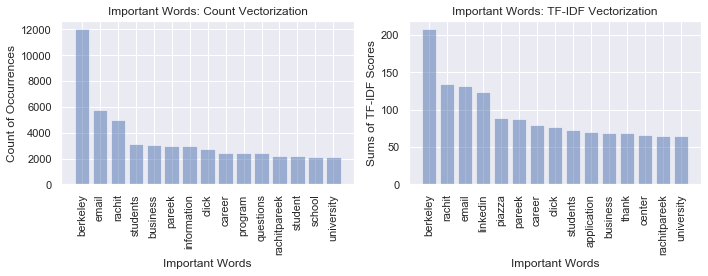

In [1420]:
# Because the matrices are sparse, we can't interpret much from them. Let's visualize which words are the most 
# common & have the most importance under both vectorization schemes:
cv_sums = vector_table_sum(cv_word_vectors, "Sum of Counts")
tv_sums = vector_table_sum(tv_word_vectors, "Sum of Scores")

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15)["Sum of Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Count of Occurrences')
plt.title('Important Words: Count Vectorization')

plt.subplot(122)
plt.bar(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15)["Sum of Scores"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Sums of TF-IDF Scores')
plt.title('Important Words: TF-IDF Vectorization')

plt.tight_layout();

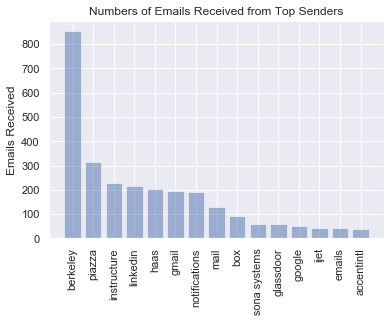

In [1421]:
top_senders = get_top_senders(training_data, 15)

plt.bar(np.arange(len(top_senders)), np.array(top_senders["Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(top_senders)), np.array(top_senders.index), rotation='vertical')
plt.ylabel('Emails Received')
plt.title('Numbers of Emails Received from Top Senders')
plt.show()

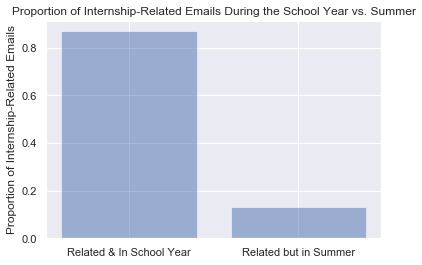

In [1422]:
# This visualization seems to show that there's a strong connection between whether the email was sent during a school
# month and whether it was an internship-related email. The grind really concentrates itself in school months, and
# it would be odd, after all, to already be searching for another internship while working another one during the summer!
both = len(training_data[(training_data["In School Year"] > 0) & (training_data["Internship-Related"] > 0)])/len(training_data[(training_data["Internship-Related"] > 0)])
summer_internship = len(training_data[(training_data["In School Year"] == 0) & (training_data["Internship-Related"] > 0)])/len(training_data[(training_data["Internship-Related"] > 0)])
plt.bar(np.arange(2), [both, summer_internship], align='center', alpha=0.5)
plt.xticks(np.arange(2), 
           ["Related & In School Year", "Related but in Summer"])
plt.ylabel('Proportion of Internship-Related Emails')
plt.title('Proportion of Internship-Related Emails During the School Year vs. Summer')
plt.show()

In [1448]:
# Let's create a dataframe we can use for modeling, adding in the TF-IDF vector representations for the top 15 terms
# per email, and dropping unneeded columns. 
def make_modeling_data(table, num_words, num_senders):
    top_senders = get_top_senders(table, num_senders)
    temp, word_vectors = cv_and_tfidf_vectorize(table)
    top_words = vector_table_sum(testing_tv_word_vectors, "Sum of Scores")
    # 1. Word features (from body text):
    modeling_data = word_vectors[top_words.head(num_words).index] 
    # 2. Whether the email was during the school year:
    modeling_data["In School Year"] = table["In School Year"]
    # 3. Normalized length of the email's body.
    modeling_data["Length"] = table["Length"]
    # 4. Whether the email was from one of my top senders. 
    # this will be ok if num is greater than len
    indices = ["Sender: " + i for i in top_senders.head(num_senders).index]
    modeling_data[indices] = table[indices]
    return modeling_data
    

In [1457]:
results = []
percent_done = 0
for num in range(0, 500, 25):
    
    percent_done += 100/((500-0)/25)
    
    words = num
    senders = 0

    X_train = make_modeling_data(training_data, words, senders)
    X_test = make_modeling_data(testing_data, words, senders)

#     print(f'Number of features: {len(X_train.columns)}')
#     print(f'Training set size: {len(y_train)}')
#     print(f'Test set size: {len(y_test)}')

    #Now, let's fit our model.
    logistic_model = LogisticRegression(max_iter=5000)
    logistic_model.fit(X_train, training_data["Internship-Related"])

    score = logistic_model.score(X_test, testing_data["Internship-Related"])
    coefs = logistic_model.coef_
    logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, logistic_model_probabilities)
    results.append((words, score, auc))
    print(percent_done)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


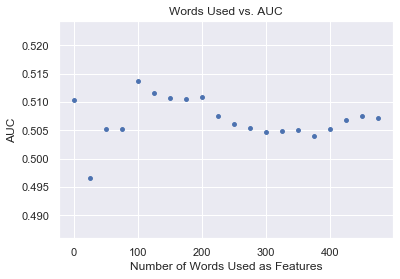

In [1458]:
word_nums, aucs = [i[0] for i in results], [i[2] for i in results]
plt.scatter(word_nums, aucs, s=15)
plt.title('Words Used vs. AUC')
plt.xlabel('Number of Words Used as Features')
plt.ylabel('AUC');

In [1459]:
results = []
percent_done = 0
for num in range(0, 50, 5):
    
    percent_done += 100/((50-0)/5)
    
    words = 100
    senders = num

    X_train = make_modeling_data(training_data, words, senders)
    X_test = make_modeling_data(testing_data, words, senders)

#     print(f'Number of features: {len(X_train.columns)}')
#     print(f'Training set size: {len(y_train)}')
#     print(f'Test set size: {len(y_test)}')

    #Now, let's fit our model.
    logistic_model = LogisticRegression(max_iter=5000)
    logistic_model.fit(X_train, training_data["Internship-Related"])

    score = logistic_model.score(X_test, testing_data["Internship-Related"])
    coefs = logistic_model.coef_
    logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, logistic_model_probabilities)
    results.append((senders, score, auc))
    print(percent_done)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


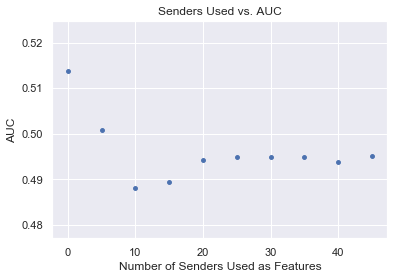

In [1460]:
sender_nums, aucs = [i[0] for i in results], [i[2] for i in results]
plt.scatter(sender_nums, aucs, s=15)
plt.title('Senders Used vs. AUC')
plt.xlabel('Number of Senders Used as Features')
plt.ylabel('AUC');

In [1464]:
X_train = make_modeling_data(training_data, 100, 0)
X_test = make_modeling_data(testing_data, 100, 0)

#Now, let's fit our model.
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(X_train, training_data["Internship-Related"])

score = logistic_model.score(X_test, testing_data["Internship-Related"])
logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, logistic_model_probabilities)
print(f'Number of features: {len(X_train.columns)}')
print(f'Score: {score}')
print(f'AUC: {auc}')

Number of features: 102
Score: 0.8968968968968969
AUC: 0.5136754836162654


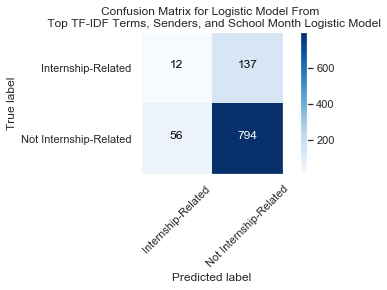

In [1465]:
#confusion matrix to analyze
class_names = ["Internship-Related", "Not Internship-Related"]
conf_mat = confusion_matrix(y_test, logistic_model.predict(X_test), labels=[1, 0])
plot_confusion_matrix(conf_mat, classes=class_names, title='Confusion Matrix for Logistic Model From '
                      + '\n Top TF-IDF Terms, Senders, and School Month Logistic Model')

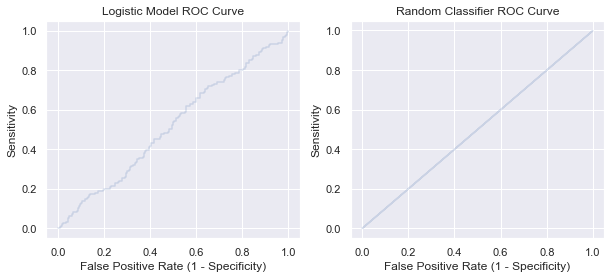

In [1466]:
logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, logistic_model_probabilities, pos_label=1)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Logistic Model ROC Curve')

plt.subplot(122)
plt.step(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001), color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Random Classifier ROC Curve')
plt.show();